# 🔬 Scale Comparison Viewer (0.0 vs 1.0)

PCA Context Vector의 Scale(0.0과 1.0)에 따른 답변 차이를 분석하는 전문 노트북입니다.

---

## 📋 주요 기능
- ✅ Scale 0.0 vs 1.0 답변 비교 시각화
- 🖼️ 이미지와 질문 표시
- 💭 추론 과정 분석
- 🏆 Thought Anchor 랭킹
- 🎯 정답률 비교 및 통계 분석
- 📊 Scale별 성능 차이 시각화

## 1️⃣ 라이브러리 임포트

In [1]:
import json
import numpy as np
from pathlib import Path
from PIL import Image
from IPython.display import display, HTML, Markdown
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import textwrap
import warnings
warnings.filterwarnings('ignore')

print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


## 2️⃣ Scale 비교 시각화 함수 정의

In [ ]:
def display_scale_comparison(json_path, show_contrastive=True, show_anchors=True):
    """Scale 0.0 vs 1.0 결과를 비교하여 표시
    
    Args:
        json_path: JSON 파일 경로
        show_contrastive: Contrastive Generation 결과 표시 여부
        show_anchors: Thought Anchor 표시 여부
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    example_name = json_path.stem
    
    # 헤더
    display(HTML(f"""
        <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                    color: white; padding: 20px; border-radius: 10px; margin-bottom: 20px;
                    box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
            <h2 style="margin: 0; font-size: 24px;">🔬 {example_name.upper().replace('_', ' ')} - SCALE COMPARISON</h2>
            <p style="margin: 5px 0 0 0; opacity: 0.9; font-size: 14px;">
                Example Index: {data.get('example_idx', 'N/A')} | 
                QA Pairs: {data.get('successful_pairs', 0)}/{data.get('total_pairs', 0)}
            </p>
        </div>
    """))
    
    # 에러 체크
    if 'error' in data:
        display(HTML(f"""
            <div style="background: #ffebee; color: #c62828; padding: 15px; 
                        border-left: 4px solid #f44336; border-radius: 5px;">
                ❌ <strong>Error:</strong> {data['error']}
            </div>
        """))
        return
    
    if data.get('successful_pairs', 0) == 0:
        display(HTML("""
            <div style="color: #999; font-style: italic; padding: 20px; text-align: center;
                        background: #f5f5f5; border-radius: 5px;">
                ⚠️ No successful QA pairs in this example
            </div>
        """))
        return
    
    # 이미지 로드
    image_path = data.get('image_path')
    image = None
    if image_path and Path(image_path).exists():
        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"⚠️ Failed to load image: {e}")
    
    # 각 QA pair 처리
    for qa_idx, qa_pair in enumerate(data.get('qa_pairs', [])):
        display(HTML(f"""
            <div style="background: linear-gradient(90deg, #f5f5f5 0%, #e0e0e0 100%); 
                        padding: 12px; margin: 25px 0; border-radius: 5px; 
                        font-weight: bold; font-size: 16px; color: #333;">
                📝 QA Pair {qa_idx + 1} (Pair Index: {qa_pair.get('pair_idx', 'N/A')})
            </div>
        """))
        
        # Question 파싱
        question = qa_pair.get('question', '')
        if '<|vision_start|>' in question:
            parts = question.split('\n')
            question = '\n'.join([p for p in parts if '<|vision_' not in p and '<|image_' not in p])
        
        # 레이아웃: 이미지 + 질문
        fig = plt.figure(figsize=(18, 6))
        
        # 왼쪽: 이미지
        ax_img = plt.subplot(1, 2, 1)
        if image is not None:
            ax_img.imshow(image)
            ax_img.axis('off')
            ax_img.set_title('🖼️ Image', fontsize=14, fontweight='bold', pad=10)
        else:
            ax_img.text(0.5, 0.5, '❌ No Image Available', 
                       ha='center', va='center', fontsize=14, color='gray')
            ax_img.set_xlim(0, 1)
            ax_img.set_ylim(0, 1)
            ax_img.axis('off')
        
        # 오른쪽: 질문
        ax_text = plt.subplot(1, 2, 2)
        ax_text.axis('off')
        
        y_pos = 0.95
        ax_text.add_patch(Rectangle((0, y_pos - 0.85), 1, 0.85, 
                                    facecolor='#e3f2fd', edgecolor='#2196f3', linewidth=2))
        ax_text.text(0.02, y_pos - 0.02, '❓ Question:', 
                    fontsize=12, fontweight='bold', color='#1976d2')
        
        wrapped_q = '\n'.join(textwrap.wrap(question.strip(), width=65))
        ax_text.text(0.02, y_pos - 0.08, wrapped_q, 
                    fontsize=10, verticalalignment='top', family='monospace')
        
        ax_text.set_xlim(0, 1)
        ax_text.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
        
        # Scale 결과 추출
        pca_context = qa_pair.get('contrastive', {}).get('pca_context', {})
        scale_results = pca_context.get('results', {})
        
        scale_0 = scale_results.get('0.0', 'N/A')
        scale_1 = scale_results.get('1.0', 'N/A')
        correct_answer = qa_pair.get('contrastive', {}).get('correct_answer', 'N/A')
        
        # Scale 비교 박스
        display(HTML("""
            <div style="background: #fff; padding: 15px; border-radius: 10px; 
                        border: 2px solid #667eea; margin-top: 20px;">
                <h3 style="color: #667eea; margin-top: 0;">⚖️ Scale Comparison (0.0 vs 1.0)</h3>
                <p style="color: #666; font-size: 13px; margin: 5px 0;">
                    PCA Context Vector의 스케일에 따른 답변 차이를 비교합니다.
                </p>
            </div>
        """))
        
        # Scale 0.0 vs 1.0 비교
        # 정답 체크
        def is_answer_correct(answer, correct):
            """답변이 정답과 일치하는지 확인"""
            if answer == 'N/A' or correct == 'N/A':
                return None
            # 옵션 추출 (예: "(C) Vanuatu" -> "C")
            import re
            answer_match = re.search(r'\(([A-D])\)', answer)
            correct_match = re.search(r'\b([A-D])\b', correct)
            
            if answer_match and correct_match:
                return answer_match.group(1) == correct_match.group(1)
            return None
        
        scale_0_correct = is_answer_correct(scale_0, correct_answer)
        scale_1_correct = is_answer_correct(scale_1, correct_answer)
        
        # Scale 0.0 색상
        if scale_0_correct is True:
            scale_0_bg = '#e8f5e9'
            scale_0_border = '#4caf50'
            scale_0_icon = '✅'
        elif scale_0_correct is False:
            scale_0_bg = '#ffebee'
            scale_0_border = '#f44336'
            scale_0_icon = '❌'
        else:
            scale_0_bg = '#f5f5f5'
            scale_0_border = '#999'
            scale_0_icon = '❓'
        
        # Scale 1.0 색상
        if scale_1_correct is True:
            scale_1_bg = '#e8f5e9'
            scale_1_border = '#4caf50'
            scale_1_icon = '✅'
        elif scale_1_correct is False:
            scale_1_bg = '#ffebee'
            scale_1_border = '#f44336'
            scale_1_icon = '❌'
        else:
            scale_1_bg = '#f5f5f5'
            scale_1_border = '#999'
            scale_1_icon = '❓'
        
        display(HTML(f"""
            <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin: 15px 0;">
                <!-- Scale 0.0 -->
                <div style="background: {scale_0_bg}; padding: 20px; border-radius: 10px; 
                            border-left: 6px solid {scale_0_border}; box-shadow: 0 2px 8px rgba(0,0,0,0.1);">
                    <h4 style="margin: 0 0 15px 0; color: #333; font-size: 18px;">
                        🔵 Scale 0.0 {scale_0_icon}
                    </h4>
                    <div style="background: white; padding: 15px; border-radius: 5px; 
                                font-family: monospace; font-size: 14px; color: #333; 
                                min-height: 60px; display: flex; align-items: center;">
                        <strong>{scale_0}</strong>
                    </div>
                </div>
                
                <!-- Scale 1.0 -->
                <div style="background: {scale_1_bg}; padding: 20px; border-radius: 10px; 
                            border-left: 6px solid {scale_1_border}; box-shadow: 0 2px 8px rgba(0,0,0,0.1);">
                    <h4 style="margin: 0 0 15px 0; color: #333; font-size: 18px;">
                        🟢 Scale 1.0 {scale_1_icon}
                    </h4>
                    <div style="background: white; padding: 15px; border-radius: 5px; 
                                font-family: monospace; font-size: 14px; color: #333; 
                                min-height: 60px; display: flex; align-items: center;">
                        <strong>{scale_1}</strong>
                    </div>
                </div>
            </div>
        """))
        
        # 정답 표시
        display(HTML(f"""
            <div style="background: #e3f2fd; padding: 15px; border-radius: 8px; 
                        border-left: 4px solid #2196f3; margin: 15px 0;">
                <strong style="color: #1976d2; font-size: 16px;">🎯 Correct Answer:</strong> 
                <span style="color: #333; font-size: 15px; font-family: monospace;"><strong>{correct_answer}</strong></span>
            </div>
        """))
        
        # 비교 결과 요약
        if scale_0 == scale_1:
            comparison_text = "두 스케일이 동일한 답변을 생성했습니다."
            comparison_color = "#2196f3"
            comparison_bg = "#e3f2fd"
        else:
            comparison_text = "두 스케일이 서로 다른 답변을 생성했습니다!"
            comparison_color = "#ff9800"
            comparison_bg = "#fff3e0"
        
        display(HTML(f"""
            <div style="background: {comparison_bg}; padding: 12px; border-radius: 5px; 
                        border-left: 4px solid {comparison_color}; margin: 10px 0; text-align: center;">
                <strong style="color: {comparison_color};">📊 {comparison_text}</strong>
            </div>
        """))
        
        # Thought Anchor Rankings
        if show_anchors:
            chunks = qa_pair.get('chunks', [])
            anchor_vector = qa_pair.get('anchor_vector', [])
            
            if len(chunks) > 0 and len(anchor_vector) > 0:
                display(HTML("""
                    <div style="background: #fff; padding: 15px; border-radius: 10px; 
                                border: 2px solid #9c27b0; margin-top: 20px;">
                        <h3 style="color: #9c27b0; margin-top: 0;">🏆 Thought Anchor Rankings</h3>
                        <p style="color: #666; font-size: 13px; margin: 5px 0;">
                            추론 과정에서 각 문장의 중요도를 Anchor Score로 평가합니다.
                        </p>
                    </div>
                """))
                
                # Anchor 정렬
                anchor_pairs = list(zip(range(len(chunks)), chunks, anchor_vector))
                anchor_pairs.sort(key=lambda x: x[2], reverse=True)
                
                # Top 5만
                top_anchors = anchor_pairs[:5]
                
                if any(score > 0 for _, _, score in top_anchors):
                    for rank, (chunk_idx, chunk, score) in enumerate(top_anchors, 1):
                        # 텍스트 정리
                        text = chunk
                        for tag in ['<reasoning>', '</reasoning>', '<think>', '</think>', 
                                   '<final>', '</final>', '<SUMMARY>', '</SUMMARY>',
                                   '<CAPTION>', '</CAPTION>', '<REASONING>', '</REASONING>',
                                   '<CONCLUSION>', '</CONCLUSION>']:
                            text = text.replace(tag, '')
                        text = text.strip()
                        
                        # 색상 선택 (순위별)
                        colors = {
                            1: ('#ffebee', '#f44336', '🥇'),
                            2: ('#fff3e0', '#ff9800', '🥈'),
                            3: ('#fffde7', '#ffc107', '🥉'),
                            4: ('#e8f5e9', '#4caf50', '4️⃣'),
                            5: ('#e3f2fd', '#2196f3', '5️⃣')
                        }
                        bg_color, border_color, medal = colors.get(rank, ('#f5f5f5', '#999', '•'))
                        
                        display(HTML(f"""
                            <div style="background: {bg_color}; padding: 12px; margin: 10px 0; 
                                        border-left: 5px solid {border_color}; border-radius: 5px;
                                        box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
                                <div style="display: flex; justify-content: space-between; 
                                            align-items: center; margin-bottom: 5px;">
                                    <strong style="font-size: 16px;">
                                        {medal} Rank {rank} (Chunk {chunk_idx + 1})
                                    </strong>
                                    <span style="background: rgba(0,0,0,0.1); padding: 4px 12px; 
                                                border-radius: 12px; font-size: 14px; font-weight: bold;">
                                        Score: {score:.4f}
                                    </span>
                                </div>
                                <div style="color: #555; font-size: 14px; line-height: 1.5;">
                                    {text}
                                </div>
                            </div>
                        """))
                else:
                    display(HTML("""
                        <div style="color: #999; font-style: italic; padding: 20px; text-align: center;
                                    background: #f5f5f5; border-radius: 5px;">
                            ⚠️ All anchor scores are zero
                        </div>
                    """))
        
        # Contrastive Generation 결과
        if show_contrastive and 'contrastive' in qa_pair:
            contrastive = qa_pair['contrastive']
            
            display(HTML("""
                <div style="background: #fff; padding: 15px; border-radius: 10px; 
                            border: 2px solid #ff6b6b; margin-top: 20px;">
                    <h3 style="color: #ff6b6b; margin-top: 0;">🔄 Contrastive Generation Results</h3>
                    <p style="color: #666; font-size: 13px; margin: 5px 0;">
                        긍정/부정 샘플을 통한 대조 학습 결과입니다.
                    </p>
                </div>
            """))
            
            # Positive vs Negative
            pos_prob = contrastive.get('positive_probability', 0)
            neg_prob = contrastive.get('negative_probability', 0)
            
            display(HTML(f"""
                <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px; margin: 15px 0;">
                    <div style="background: #e8f5e9; padding: 15px; border-radius: 8px; 
                                border-left: 4px solid #4caf50;">
                        <h4 style="margin: 0 0 10px 0; color: #2e7d32;">✅ Positive Sample</h4>
                        <p style="margin: 5px 0; font-size: 13px; color: #555;">
                            <strong>Probability:</strong> {pos_prob:.4f}
                        </p>
                        <p style="margin: 10px 0 0 0; font-size: 13px; color: #333; 
                                   background: white; padding: 10px; border-radius: 5px;">
                            {contrastive.get('positive_sentence', 'N/A')}
                        </p>
                    </div>
                    <div style="background: #ffebee; padding: 15px; border-radius: 8px; 
                                border-left: 4px solid #f44336;">
                        <h4 style="margin: 0 0 10px 0; color: #c62828;">❌ Negative Sample</h4>
                        <p style="margin: 5px 0; font-size: 13px; color: #555;">
                            <strong>Probability:</strong> {neg_prob:.4f}
                        </p>
                        <p style="margin: 10px 0 0 0; font-size: 13px; color: #333; 
                                   background: white; padding: 10px; border-radius: 5px;">
                            {contrastive.get('negative_sentence', 'N/A')}
                        </p>
                    </div>
                </div>
            """))
            
            # Probability Difference
            prob_diff = pos_prob - neg_prob
            if prob_diff > 0:
                diff_color = '#4caf50'
                diff_text = f"+{prob_diff:.4f} (Positive가 더 높음)"
            elif prob_diff < 0:
                diff_color = '#f44336'
                diff_text = f"{prob_diff:.4f} (Negative가 더 높음)"
            else:
                diff_color = '#999'
                diff_text = "0.0000 (동일)"
            
            display(HTML(f"""
                <div style="background: #f5f5f5; padding: 12px; border-radius: 5px; 
                            border-left: 4px solid {diff_color}; margin: 10px 0; text-align: center;">
                    <strong style="color: {diff_color};">📈 Probability Difference: {diff_text}</strong>
                </div>
            """))
        
        # 구분선
        display(HTML('<hr style="border: 2px solid #ddd; margin: 40px 0;">'))

## 3️⃣ 결과 파일 목록 확인

In [3]:
# outputs 폴더 경로 설정
output_dir = Path('outputs')

if not output_dir.exists():
    print(f"❌ Error: '{output_dir}' 폴더를 찾을 수 없습니다.")
    print(f"   현재 작업 디렉토리: {Path.cwd()}")
else:
    result_files = sorted(output_dir.glob('example_*.json'))
    
    print(f"\n📂 총 {len(result_files)}개의 결과 파일을 발견했습니다:\n")
    print("=" * 70)
    
    successful_count = 0
    failed_count = 0
    
    for i, f in enumerate(result_files):
        size_kb = f.stat().st_size / 1024
        
        try:
            with open(f, 'r') as jf:
                data = json.load(jf)
                
                if 'error' in data:
                    status = "⚠️ ERROR"
                    failed_count += 1
                elif data.get('successful_pairs', 0) > 0:
                    status = "✅ SUCCESS"
                    successful_count += 1
                else:
                    status = "❌ FAILED"
                    failed_count += 1
                
                pairs = data.get('total_pairs', 0)
                success_pairs = data.get('successful_pairs', 0)
                
                print(f"  {i:2d}. {status} | {f.name:20s} | {size_kb:6.1f} KB | Pairs: {success_pairs}/{pairs}")
        except Exception as e:
            print(f"  {i:2d}. ⚠️ PARSE ERROR | {f.name:20s} | {size_kb:6.1f} KB | Error: {e}")
            failed_count += 1
    
    print("=" * 70)
    print(f"\n📊 요약: 성공 {successful_count}개 | 실패 {failed_count}개")
    print(f"\n✨ 분석을 시작하려면 아래 셀을 실행하세요!")


📂 총 3개의 결과 파일을 발견했습니다:

   0. ✅ SUCCESS | example_0.json       |   11.6 KB | Pairs: 1/1
   1. ✅ SUCCESS | example_1.json       |   17.5 KB | Pairs: 2/2
   2. ✅ SUCCESS | example_2.json       |   13.1 KB | Pairs: 1/1

📊 요약: 성공 3개 | 실패 0개

✨ 분석을 시작하려면 아래 셀을 실행하세요!


## 4️⃣ 특정 예제의 Scale 비교 보기

특정 예제를 선택해서 Scale 0.0 vs 1.0 결과를 상세히 비교합니다.

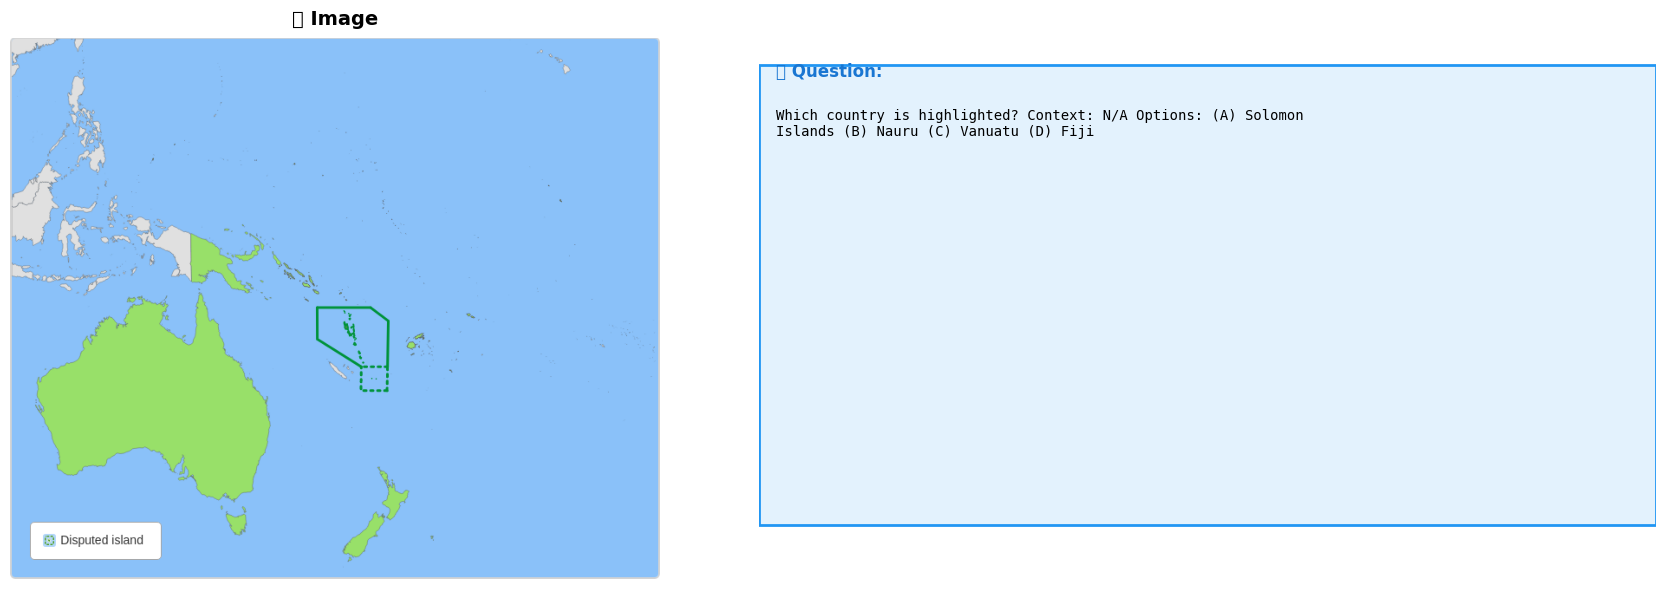

In [4]:
# 보고 싶은 예제 번호를 입력하세요 (0부터 시작)
EXAMPLE_NUM = 0

example_path = output_dir / f'example_{EXAMPLE_NUM}.json'

if example_path.exists():
    display_scale_comparison(example_path, show_contrastive=True, show_anchors=True)
else:
    print(f"❌ {example_path} 파일을 찾을 수 없습니다.")

## 5️⃣ 모든 예제의 Scale 비교 자동 표시

모든 성공한 예제들의 Scale 비교를 순차적으로 표시합니다.

In [ ]:
# 성공한 예제만 필터링
successful_files = []

for f in result_files:
    try:
        with open(f, 'r') as jf:
            data = json.load(jf)
            if data.get('successful_pairs', 0) > 0 and 'error' not in data:
                successful_files.append(f)
    except:
        continue

print(f"\n🎯 총 {len(successful_files)}개의 성공한 예제를 표시합니다.\n")
print("=" * 70)

# 각 성공한 예제 표시
for i, json_path in enumerate(successful_files, 1):
    print(f"\n\n{'='*70}")
    print(f"📌 성공 예제 {i}/{len(successful_files)}: {json_path.name}")
    print(f"{'='*70}\n")
    
    display_scale_comparison(json_path, show_contrastive=True, show_anchors=True)

print("\n" + "=" * 70)
print(f"✅ 모든 성공 예제 ({len(successful_files)}개) Scale 비교 완료!")
print("=" * 70)

## 6️⃣ Scale별 통계 분석

Scale 0.0과 1.0의 정답률 및 성능 차이를 통계적으로 분석합니다.


📊 Scale 0.0 vs 1.0 전체 통계

📁 기본 정보:
  • 전체 예제: 3개
  • 성공한 QA Pairs: 4개

🔵 Scale 0.0 성능:
  • 정답: 0개
  • 오답: 1개
  • 정확도: 0.00%

🟢 Scale 1.0 성능:
  • 정답: 1개
  • 오답: 0개
  • 정확도: 100.00%

⚖️ 비교 분석:
  • 둘 다 정답: 0개 (0.0%)
  • 둘 다 오답: 0개 (0.0%)
  • Scale 0.0만 정답: 0개 (0.0%)
  • Scale 1.0만 정답: 1개 (100.0%)

📋 답변 일치도:
  • 동일한 답변: 0개 (0.0%)
  • 다른 답변: 1개 (100.0%)

🎯 성능 차이:
  • Scale 1.0이 100.00%p 더 높음 ✅

🔄 Contrastive Probability:
  • 평균 Positive Prob: 0.7935
  • 평균 Negative Prob: 0.6058
  • Prob 차이: 0.1876



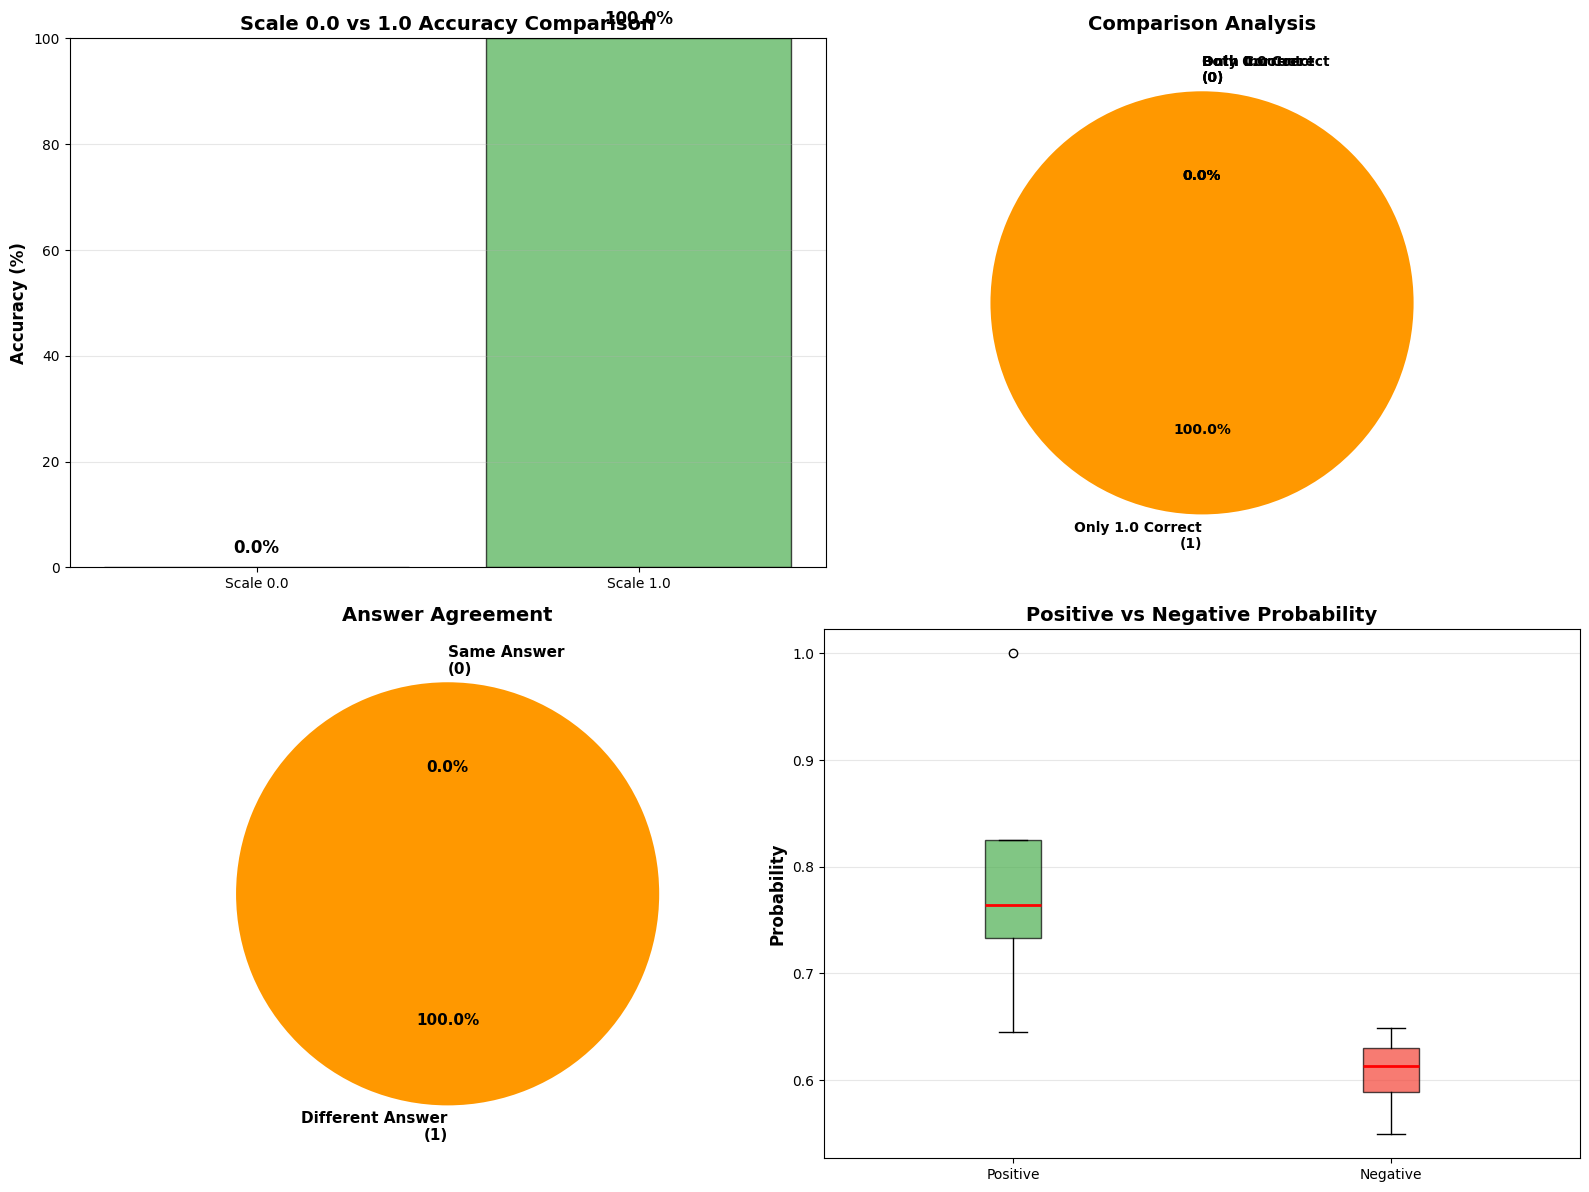

In [5]:
import re

# 통계 수집
stats = {
    'total_examples': 0,
    'successful_examples': 0,
    'scale_0_correct': 0,
    'scale_1_correct': 0,
    'scale_0_incorrect': 0,
    'scale_1_incorrect': 0,
    'both_correct': 0,
    'both_incorrect': 0,
    'only_0_correct': 0,
    'only_1_correct': 0,
    'same_answer': 0,
    'different_answer': 0,
    'anchor_scores': [],
    'positive_probs': [],
    'negative_probs': []
}

def extract_option(text):
    """답변에서 옵션 추출 (예: "(C) Vanuatu" -> "C")"""
    if not text or text == 'N/A':
        return None
    match = re.search(r'\(([A-D])\)', text)
    if match:
        return match.group(1)
    match = re.search(r'\b([A-D])\b', text)
    if match:
        return match.group(1)
    return None

for f in result_files:
    try:
        with open(f, 'r') as jf:
            data = json.load(jf)
            
            if 'error' in data or data.get('successful_pairs', 0) == 0:
                continue
            
            stats['total_examples'] += 1
            stats['successful_examples'] += data.get('successful_pairs', 0)
            
            # QA pairs 분석
            for qa in data.get('qa_pairs', []):
                contrastive = qa.get('contrastive', {})
                pca_context = contrastive.get('pca_context', {})
                scale_results = pca_context.get('results', {})
                
                scale_0 = scale_results.get('0.0', 'N/A')
                scale_1 = scale_results.get('1.0', 'N/A')
                correct_answer = contrastive.get('correct_answer', 'N/A')
                
                # 옵션 추출
                scale_0_opt = extract_option(scale_0)
                scale_1_opt = extract_option(scale_1)
                correct_opt = extract_option(correct_answer)
                
                if scale_0_opt and scale_1_opt and correct_opt:
                    # 정답 여부 체크
                    scale_0_is_correct = (scale_0_opt == correct_opt)
                    scale_1_is_correct = (scale_1_opt == correct_opt)
                    
                    if scale_0_is_correct:
                        stats['scale_0_correct'] += 1
                    else:
                        stats['scale_0_incorrect'] += 1
                    
                    if scale_1_is_correct:
                        stats['scale_1_correct'] += 1
                    else:
                        stats['scale_1_incorrect'] += 1
                    
                    # 비교 분석
                    if scale_0_is_correct and scale_1_is_correct:
                        stats['both_correct'] += 1
                    elif not scale_0_is_correct and not scale_1_is_correct:
                        stats['both_incorrect'] += 1
                    elif scale_0_is_correct:
                        stats['only_0_correct'] += 1
                    elif scale_1_is_correct:
                        stats['only_1_correct'] += 1
                    
                    # 답변 동일 여부
                    if scale_0 == scale_1:
                        stats['same_answer'] += 1
                    else:
                        stats['different_answer'] += 1
                
                # Anchor scores
                anchor_vec = qa.get('anchor_vector', [])
                if anchor_vec:
                    stats['anchor_scores'].extend([s for s in anchor_vec if s > 0])
                
                # Contrastive probabilities
                pos_prob = contrastive.get('positive_probability')
                neg_prob = contrastive.get('negative_probability')
                if pos_prob is not None:
                    stats['positive_probs'].append(pos_prob)
                if neg_prob is not None:
                    stats['negative_probs'].append(neg_prob)
    except Exception as e:
        print(f"⚠️ Error processing {f.name}: {e}")
        continue

# 통계 출력
print("\n" + "=" * 70)
print("📊 Scale 0.0 vs 1.0 전체 통계")
print("=" * 70)

print(f"\n📁 기본 정보:")
print(f"  • 전체 예제: {stats['total_examples']}개")
print(f"  • 성공한 QA Pairs: {stats['successful_examples']}개")

total_qa = stats['scale_0_correct'] + stats['scale_0_incorrect']
if total_qa > 0:
    print(f"\n🔵 Scale 0.0 성능:")
    scale_0_acc = stats['scale_0_correct'] / total_qa * 100
    print(f"  • 정답: {stats['scale_0_correct']}개")
    print(f"  • 오답: {stats['scale_0_incorrect']}개")
    print(f"  • 정확도: {scale_0_acc:.2f}%")
    
    print(f"\n🟢 Scale 1.0 성능:")
    scale_1_acc = stats['scale_1_correct'] / total_qa * 100
    print(f"  • 정답: {stats['scale_1_correct']}개")
    print(f"  • 오답: {stats['scale_1_incorrect']}개")
    print(f"  • 정확도: {scale_1_acc:.2f}%")
    
    print(f"\n⚖️ 비교 분석:")
    print(f"  • 둘 다 정답: {stats['both_correct']}개 ({stats['both_correct']/total_qa*100:.1f}%)")
    print(f"  • 둘 다 오답: {stats['both_incorrect']}개 ({stats['both_incorrect']/total_qa*100:.1f}%)")
    print(f"  • Scale 0.0만 정답: {stats['only_0_correct']}개 ({stats['only_0_correct']/total_qa*100:.1f}%)")
    print(f"  • Scale 1.0만 정답: {stats['only_1_correct']}개 ({stats['only_1_correct']/total_qa*100:.1f}%)")
    
    print(f"\n📋 답변 일치도:")
    print(f"  • 동일한 답변: {stats['same_answer']}개 ({stats['same_answer']/total_qa*100:.1f}%)")
    print(f"  • 다른 답변: {stats['different_answer']}개 ({stats['different_answer']/total_qa*100:.1f}%)")
    
    print(f"\n🎯 성능 차이:")
    acc_diff = scale_1_acc - scale_0_acc
    if acc_diff > 0:
        print(f"  • Scale 1.0이 {acc_diff:.2f}%p 더 높음 ✅")
    elif acc_diff < 0:
        print(f"  • Scale 0.0이 {abs(acc_diff):.2f}%p 더 높음 ✅")
    else:
        print(f"  • 동일한 성능")

if stats['positive_probs'] and stats['negative_probs']:
    print(f"\n🔄 Contrastive Probability:")
    print(f"  • 평균 Positive Prob: {np.mean(stats['positive_probs']):.4f}")
    print(f"  • 평균 Negative Prob: {np.mean(stats['negative_probs']):.4f}")
    print(f"  • Prob 차이: {np.mean(stats['positive_probs']) - np.mean(stats['negative_probs']):.4f}")

print("\n" + "=" * 70)

# 시각화
if total_qa > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 정확도 비교 (막대 그래프)
    ax1 = axes[0, 0]
    scales = ['Scale 0.0', 'Scale 1.0']
    accuracies = [scale_0_acc, scale_1_acc]
    colors_bar = ['#2196f3', '#4caf50']
    bars = ax1.bar(scales, accuracies, color=colors_bar, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Scale 0.0 vs 1.0 Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 100)
    ax1.grid(True, alpha=0.3, axis='y')
    # 값 표시
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{acc:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # 2. 비교 분석 (파이 차트)
    ax2 = axes[0, 1]
    comparison_data = [
        stats['both_correct'],
        stats['both_incorrect'],
        stats['only_0_correct'],
        stats['only_1_correct']
    ]
    comparison_labels = [
        f'Both Correct\n({stats["both_correct"]})',
        f'Both Incorrect\n({stats["both_incorrect"]})',
        f'Only 0.0 Correct\n({stats["only_0_correct"]})',
        f'Only 1.0 Correct\n({stats["only_1_correct"]})'
    ]
    colors_pie = ['#4caf50', '#f44336', '#2196f3', '#ff9800']
    ax2.pie(comparison_data, labels=comparison_labels, colors=colors_pie, autopct='%1.1f%%',
           startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
    ax2.set_title('Comparison Analysis', fontsize=14, fontweight='bold')
    
    # 3. 답변 일치도 (파이 차트)
    ax3 = axes[1, 0]
    agreement_data = [stats['same_answer'], stats['different_answer']]
    agreement_labels = [
        f'Same Answer\n({stats["same_answer"]})',
        f'Different Answer\n({stats["different_answer"]})'
    ]
    colors_agree = ['#2196f3', '#ff9800']
    ax3.pie(agreement_data, labels=agreement_labels, colors=colors_agree, autopct='%1.1f%%',
           startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax3.set_title('Answer Agreement', fontsize=14, fontweight='bold')
    
    # 4. Contrastive Probability 비교 (박스플롯)
    ax4 = axes[1, 1]
    if stats['positive_probs'] and stats['negative_probs']:
        bp = ax4.boxplot([stats['positive_probs'], stats['negative_probs']], 
                   labels=['Positive', 'Negative'],
                   patch_artist=True,
                   medianprops=dict(color='red', linewidth=2))
        bp['boxes'][0].set_facecolor('#4caf50')
        bp['boxes'][1].set_facecolor('#f44336')
        for box in bp['boxes']:
            box.set_alpha(0.7)
        ax4.set_ylabel('Probability', fontsize=12, fontweight='bold')
        ax4.set_title('Positive vs Negative Probability', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ 분석할 데이터가 없습니다.")

## 7️⃣ Scale 차이가 큰 예제 찾기

Scale 0.0과 1.0의 답변이 다른 예제들을 찾아 상세히 분석합니다.

In [6]:
# Scale 차이가 있는 예제 찾기
different_scale_examples = []

for f in result_files:
    try:
        with open(f, 'r') as jf:
            data = json.load(jf)
            
            if 'error' in data or data.get('successful_pairs', 0) == 0:
                continue
            
            for qa in data.get('qa_pairs', []):
                contrastive = qa.get('contrastive', {})
                pca_context = contrastive.get('pca_context', {})
                scale_results = pca_context.get('results', {})
                
                scale_0 = scale_results.get('0.0', 'N/A')
                scale_1 = scale_results.get('1.0', 'N/A')
                
                if scale_0 != scale_1 and scale_0 != 'N/A' and scale_1 != 'N/A':
                    different_scale_examples.append({
                        'file': f,
                        'scale_0': scale_0,
                        'scale_1': scale_1,
                        'correct': contrastive.get('correct_answer', 'N/A')
                    })
    except:
        continue

print(f"\n🔍 Scale 답변이 다른 예제: {len(different_scale_examples)}개\n")
print("=" * 70)

if different_scale_examples:
    for i, example in enumerate(different_scale_examples[:10], 1):  # 최대 10개만 표시
        print(f"\n📌 Example {i}: {example['file'].name}")
        print(f"  • Scale 0.0: {example['scale_0']}")
        print(f"  • Scale 1.0: {example['scale_1']}")
        print(f"  • Correct: {example['correct']}")
        print("-" * 70)
    
    print(f"\n💡 위 예제들을 상세히 보려면 아래 셀에서 파일을 선택하여 실행하세요.")
else:
    print("\n✅ 모든 예제에서 Scale 0.0과 1.0의 답변이 동일합니다!")

print("\n" + "=" * 70)


🔍 Scale 답변이 다른 예제: 2개


📌 Example 1: example_0.json
  • Scale 0.0: (A) Solomon Islands
  • Scale 1.0: (C) Vanuatu
  • Correct: The answer is C.
----------------------------------------------------------------------

📌 Example 2: example_2.json
  • Scale 0.0: 4. Similarly, triangles BOF and DOE are congruent by ASA, since BO = DO, angle BOF = angle DOE (vertical angles), and angle OBF = angle ODE (alternate interior angles due to parallel sides). 5. Because of this congruence, the areas of AOE and COF are equal, and the areas of BOF and DOE are equal. 6. Therefore, the total area of the parallelogram can be expressed as the sum of the areas of triangles AOE, COF, BOF, and DOE, which is 2*(AOE + BOF) since AOE = COF and BOF = DOE. 7. So, 2*(AOE + BOF) = 12, which implies AOE + BOF = 6. 8. Wait, this doesn't make sense because the options are 2, 3, 4, and I got 6, which is not among the options. I must have made a mistake. 9. Let me reconsider. The problem is asking for the sum of the ar

---

## 🎉 Scale 비교 분석 완료!

### 💡 사용 팁:
- **특정 예제 비교**: 셀 4️⃣에서 `EXAMPLE_NUM` 값을 변경
- **모든 예제 비교**: 셀 5️⃣ 실행
- **통계 분석**: 셀 6️⃣ 실행하여 전체 성능 비교
- **차이가 큰 예제 찾기**: 셀 7️⃣ 실행

### 📊 주요 분석 포인트:
1. **정확도 비교**: Scale 0.0 vs 1.0 중 어느 것이 더 나은 성능을 보이는가?
2. **일관성**: 두 Scale이 얼마나 자주 같은 답변을 생성하는가?
3. **상호 보완성**: 한 Scale만 정답을 맞추는 경우는 얼마나 되는가?
4. **대조 학습 효과**: Positive/Negative probability 차이가 정답률에 영향을 주는가?

---